## **Preparativos:** 

1) Instalar paquetes

In [1]:
# Primero instalamos los paquetes principales
!pip install -U gym torch torchvision

# Lo siguiente es necesario para renderizar los entornos gráficos
!apt-get update
!apt install xvfb
!pip3 install -U pyvirtualdisplay

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/graphics-driver

2) Importar

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import tqdm

3) Preparar vídeo para Drive

In [3]:
# Display video

from pathlib import Path
from IPython import display as ipythondisplay
import base64

def show_videos(video_path='', prefix=''):
    html=[]
    for mp4 in Path(video_path).glob('{}*.mp4'.format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                   loop controls style="height: 400px;">
                   <source src="data:video/mp4;base64,{}" type="video/mp4" />
                   </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Definir entorno a utilizar
CartPole

In [5]:
#crear el entorno
env = gym.make('CartPole-v1')
action_dim = env.action_space.n
print(f'Action dim {action_dim}')

Action dim 2


# Definir modelo
Actor critic


In [6]:
class ActorCritic(nn.Module):
    def __init__(self, in_dim, out_actions_dim):
        super().__init__()
        #redes más commpleja
        self.common=nn.Sequential(
            nn.Linear(in_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
        )
        self.actor=nn.Linear(128, out_actions_dim) #definme actor, 4
        self.critic=nn.Linear(128,1)#critico


    def forward(self, state):
        x_common=self.common(state)
        probs=F.softmax(self.actor(x_common),dim=-1)#aplica softmax en la ultima dimension (-1)
        value=self.critic(x_common)

        return probs, value

In [19]:
# class ActorCritic(nn.Module):
#     def __init__(self, in_dim, out_actions_dim):
#         super().__init__()
#         #redes más commpleja

#         self.common=nn.Linear(in_dim, 128) #o 128
#         self.actor=nn.Linear(128, out_actions_dim) #definme actor, 4
#         self.critic=nn.Linear(128,1)#critico


#     def forward(self, state):
#         x_common=self.common(state)
#         probs=F.softmax(self.actor(x_common),dim=-1)#aplica softmax en la ultima dimension (-1)
#         value=self.critic(x_common)

#         return probs, value

In [7]:
agent = ActorCritic(4,action_dim)
lr=0.01 #learning rate

optimizer = torch.optim.Adam(agent.parameters(), lr=lr)
discount = 0.9

mean_rewards = []  # <- Usa esta lista para guardar datos para hacer el plot después

# Entrenar modelo


In [8]:
#BUENO
state_dim=4
n_batches=500
n_simulation_per_batch=50

for batch in tqdm.tqdm(range(n_batches)):
    rewards=[]
    values=[]
    log_probs=[]

    for simulation in range(n_simulation_per_batch):
        done=False
        state=env.reset() #resetear entorno
        this_sim_rewards = []
        

        #bucle de simulacion
        while not done:
          #state_ohe=F.one_hot(torch.tensor([state]).to(torch.int64), num_classes=state_dim).float()
          state=torch.FloatTensor(state).unsqueeze(0)
         # state = torch.from_numpy(state).float()
          
          probs, value= agent(state)
         # print(f'probs {probs}')
          sampler=Categorical(probs)
          action=sampler.sample()
          log_action=sampler.log_prob(action)

          #print(f'Action {action}')
          next_state, reward, done, _ =env.step(int(action))

          
          this_sim_rewards.append(reward)
          values.append(value)
          log_probs.append(log_action)
          
          state=next_state

          #b
        returns = []
        future_reward = 0.0
        for r in reversed(this_sim_rewards):
            step_r = r + discount * future_reward
            returns = [step_r] + returns
            future_reward = step_r
        
        rewards.extend(returns)

        

    
    returns = torch.tensor(rewards)[None].T #añade una dimension al tensor, paraobtener la misma domension que el values T es la transpuesta
    values = torch.cat(values)
    log_probs = torch.stack(log_probs) #stack para hacer un tensor nuevo a partir de una lista de tensores
    
    returns_minus_values = returns - values
    mean_rewards.append(sum(rewards)/len(rewards)) #media de rewards por bach
    #print(mean_rewards)

    actor_loss = (-log_probs * returns_minus_values).mean()
    critic_loss = (values - returns).square().mean()#square para que sean todos positivos, media para que de un numero
    loss = actor_loss + critic_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



100%|██████████| 500/500 [1:30:21<00:00, 10.84s/it]


# Mostrar resultados gráficamente
Muestra resultados de las medias de rewards por batch

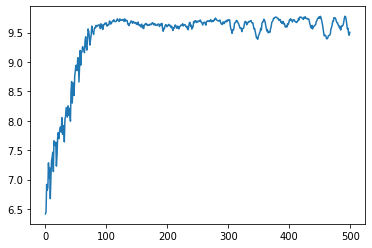

In [9]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(mean_rewards)
plt.show()

Para el vídeo

In [11]:
#para el video
import gym.wrappers as wr
from pyvirtualdisplay import Display 

display = Display(visible=0, size=(640, 480))
display.start()

env = wr.RecordVideo(env, './video5')

print(f'Action space: {env.action_space}')
print(f'Observation space: {env.observation_space}')

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [23]:
# Display video

from pathlib import Path
from IPython import display as ipythondisplay
import base64

def show_videos(video_path='', prefix=''):
  html=[]
  for mp4 in Path(video_path).glob('{}*.mp4'.format(prefix)):
    video_b64 = base64.b64encode(mp4.read_bytes())
    html.append('''<video alt="{}" autoplay
                   loop controls style="height: 400px;">
                   <source src="data:video/mp4;base64,{}" type="video/mp4" />
                   </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

show_videos('video5')

In [18]:

state = env.reset()
env.render()
done = False
total_reward = 0.
while not done:
    s=torch.FloatTensor(state).unsqueeze(0)
    probs, _ = agent.forward(s)
    sampler = Categorical(probs)
    action = sampler.sample()
    state, reward, done, _ = env.step(int(action))

    total_reward += reward

    state = next_state
    env.render()
print(f'Total reward: {total_reward}')

Total reward: 19.0


Guardar modelo

In [26]:
torch.save(agent.state_dict(), '/content/drive/MyDrive/modelo')
torch.save(optimizer.state_dict(), '/content/drive/MyDrive/optim.torch')

optimizer.load_state_dict(torch.load('/content/drive/MyDrive/optim.torch'))

torch.save(
    {
        'agent': agent.state_dict(),
        'optim': optimizer.state_dict(),
    },
    '/content/drive/MyDrive/estado.torch'
)

